# CNN-MNIST – Global Setup und Imports

In dieser Notebook-Reihe laden wir den MNIST-Datensatz, konfigurieren globale Einstellungen (Seeds, Hyperparameter etc.) und importieren die benötigten Pakete.  
Wir trainieren unser CNN zunächst für **3 Epochen**, um den Ablauf schnell zu testen. Später könnt ihr die Epochenzahl erhöhen.

Fügt diesen Text in eine Markdown-Zelle ein.


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Globaler Seed für Reproduzierbarkeit
SEED = 2
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Hyperparameter
VAL_SIZE       = 0.1     # Anteil der Validierungsdaten
EPOCHS         = 150       # Wir trainieren für 3 Epochen (schneller Einstieg)
BATCH_SIZE     = 64
LEARNING_RATE  = 0.001
PATIENCE_ES    = 7
PATIENCE_LR    = 3


# Daten Laden und Vorverarbeiten

In dieser Zelle laden wir den MNIST-Datensatz, formen die Bilder in das Format (28, 28, 1) um und normalisieren die Pixelwerte (0-255 → 0-1). Anschließend mischen wir die Trainingsdaten und teilen sie in Trainings- und Validierungs-Sets auf.


Code: Daten Laden, Aufteilen und Data Augmentation

In [ ]:
# Daten laden
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("Train Images:", train_images.shape, "Train Labels:", train_labels.shape)
print("Test Images: ", test_images.shape, "Test Labels: ", test_labels.shape)

# Reshape und Normalisierung
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
test_images  = test_images.reshape(-1, 28, 28, 1).astype('float32')  / 255.0

# Trainings-/Validierungs-Split
num_train = train_images.shape[0]
indices   = np.arange(num_train)
np.random.shuffle(indices)
split_index = int(num_train * (1 - VAL_SIZE))
train_idx   = indices[:split_index]
val_idx     = indices[split_index:]

X_train, y_train = train_images[train_idx], train_labels[train_idx]
X_val,   y_val   = train_images[val_idx],   train_labels[val_idx]
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {test_images.shape}")

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
val_generator   = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
test_generator  = test_datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE, shuffle=False)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train Images: (60000, 28, 28) Train Labels: (60000,)
Test Images:  (10000, 28, 28) Test Labels:  (10000,)
Train: (54000, 28, 28, 1), Val: (6000, 28, 28, 1), Test: (10000, 28, 28, 1)


Code: Modell bauen, trainieren (x Epochen) und Speichern/Laden

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Funktion zum Aufbau des Modells
def build_model():
    model = Sequential([
        Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),

        Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.3),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(10, activation='softmax')
    ])
    return model

# Hier kannst du den Pfad anpassen – in Colab empfiehlt sich Google Drive.
model_path = "/content/drive/MyDrive/models/my_model.h5"  # Beispielpfad in Google Drive

if os.path.exists(model_path):
    print("Lade das bereits trainierte Modell aus", model_path)
    model = tf.keras.models.load_model(model_path)
else:
    print("Kein gespeichertes Modell gefunden – starte Training.")
    model = build_model()
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ]

    # Hier kannst du z. B. für den Test 3 Epochen verwenden, später auf 150 Epochen erhöhen.
    history = model.fit(train_generator, epochs=150, validation_data=val_generator, callbacks=callbacks, verbose=1)
    # Speichere das Modell ab
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    model.save(model_path)
    print("Modell gespeichert in", model_path)


Kein gespeichertes Modell gefunden – starte Training.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,633,034 (6.23 MB)

 Trainable params: 1,631,818 (6.22 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


844/844 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.8425 - loss: 0.5164 - val_accuracy: 0.9793 - val_loss: 0.0628 - learning_rate: 0.0010
Epoch 2/150
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9637 - loss: 0.1157 - val_accuracy: 0.9850 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 3/150
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9712 - loss: 0.0914 - val_accuracy: 0.9825 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 4/150
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9756 - loss: 0.0797 - val_accuracy: 0.9875 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 5/150
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9763 - loss: 0.0778 - val_accuracy: 0.9865 - val_loss: 0.0532 - learning_rate: 0.0010
Epoch 6/150
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9781 - loss: 0.0671 - val_accuracy: 0.9885 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 7/150
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9799 - loss: 

Modell gespeichert in /content/drive/MyDrive/models/my_model.h5


Code: Evaluation, Konfusionsmatrix, Trainingsverlauf
python
Kopieren



Test Loss: 0.0139
Test Accuracy: 0.9954

Konfusionsmatrix:
 [[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1133    0    1    0    0    0    1    0    0]
 [   0    0 1030    1    0    0    0    1    0    0]
 [   0    0    1 1009    0    0    0    0    0    0]
 [   0    0    1    0  978    0    1    0    0    2]
 [   0    0    0    4    0  887    1    0    0    0]
 [   4    3    2    0    1    0  947    0    1    0]
 [   0    1    1    1    0    0    0 1023    1    1]
 [   1    1    1    2    0    1    0    0  967    1]
 [   0    0    0    0    4    1    0    3    0 1001]]

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      0.99      1.00       892
    

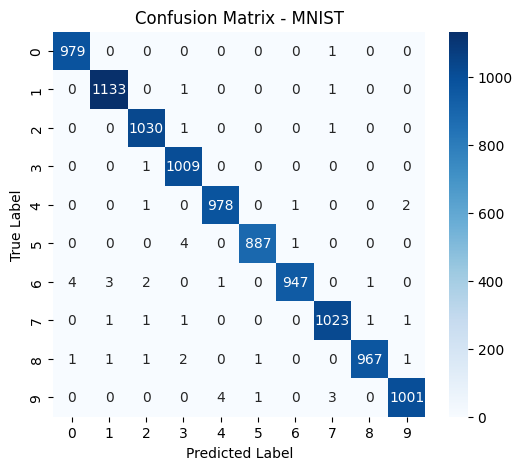

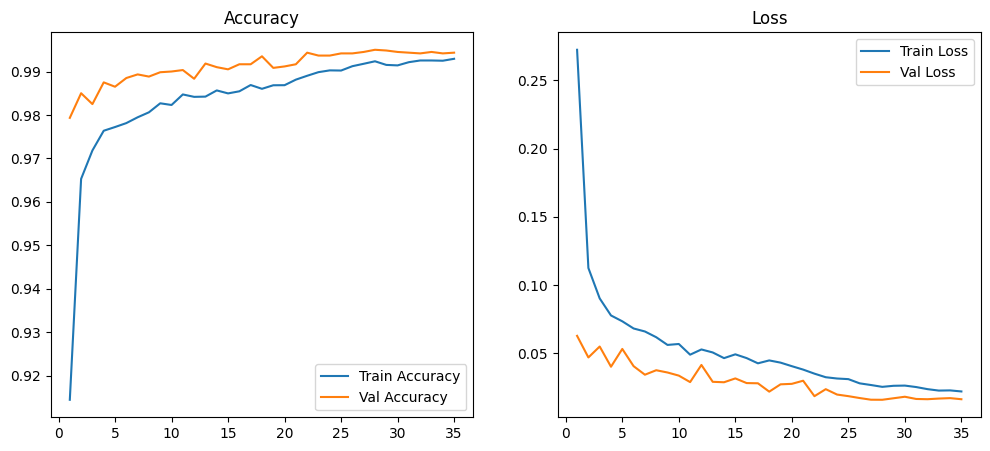

In [ ]:
# Auswertung auf Testdaten
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Konfusionsmatrix und Klassifikationsbericht
y_pred_prob = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(test_labels, y_pred)
print("\nKonfusionsmatrix:\n", cm)
print("\nKlassifikationsbericht:")
print(classification_report(test_labels, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - MNIST")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Trainingsverlauf plotten (nur wenn Training stattgefunden hat)
if 'history' in globals():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_ran = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs_ran, acc, label='Train Accuracy')
    plt.plot(epochs_ran, val_acc, label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_ran, loss, label='Train Loss')
    plt.plot(epochs_ran, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()
else:
    print("Keine Trainingshistorie verfügbar (Modell wurde geladen).")


# Weitere Analysen und Visualisierungen

Im Folgenden zeigen wir zusätzliche Analysen:

1. Falsch klassifizierte Bilder (mit Differenz der Confidence-Werte)  
2. Aktivierungskarten (Activation Maps) des ersten Conv2D-Layers  
3. Visualisierung der gelernten Filter (Kerne) des ersten Conv2D-Layers  
4. PCA und t-SNE der Embeddings (vorletzte Dense-Schicht)  
5. Einen Speedrun mit einem minimalistischen Modell

Füge diesen Text als Markdown-Zelle ein.


Code: Falsch klassifizierte Bilder anzeigen

Anzahl falsch klassifizierter Bilder: 46


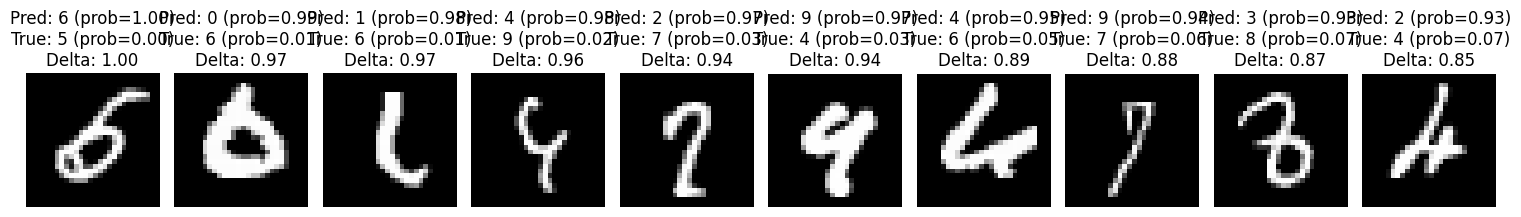

In [ ]:
# Falsch klassifizierte Bilder anzeigen
y_pred_prob = model.predict(test_images, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
wrong_idx = np.where(y_pred != test_labels)[0]
p_pred = y_pred_prob[wrong_idx, y_pred[wrong_idx]]
p_true = y_pred_prob[wrong_idx, test_labels[wrong_idx]]
delta = p_pred - p_true

sort_idx = np.argsort(-delta)
wrong_idx_sorted = wrong_idx[sort_idx]
delta_sorted = delta[sort_idx]

print("Anzahl falsch klassifizierter Bilder:", len(wrong_idx_sorted))

num_to_show = 10
plt.figure(figsize=(15, 4))
for i in range(num_to_show):
    idx = wrong_idx_sorted[i]
    img = test_images[idx].reshape(28, 28)
    plt.subplot(1, num_to_show, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    title_str = (f"Pred: {y_pred[idx]} (prob={p_pred[sort_idx[i]]:.2f})\n"
                 f"True: {test_labels[idx]} (prob={p_true[sort_idx[i]]:.2f})\n"
                 f"Delta: {delta_sorted[i]:.2f}")
    plt.title(title_str)
plt.tight_layout()
plt.show()


Code: Aktivierungskarten (Activation Maps) des ersten Conv2D-Layers
python
Kopieren


model.input ist nicht definiert – wickle das Modell um.
Neues Modell erstellt, model.input: <KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_14>
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Shape der Aktivierung nach 1. Conv2D: (1, 28, 28, 1)


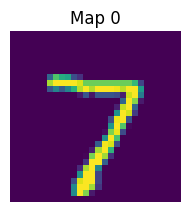

In [ ]:
# Versuche, auf model.input zuzugreifen. Falls das nicht funktioniert, umwickeln wir das Modell.
try:
    _ = model.input
    print("model.input ist definiert.")
except AttributeError as e:
    print("model.input ist nicht definiert – wickle das Modell um.")
    inp = tf.keras.Input(shape=(28, 28, 1))
    new_output = model(inp)  # Wendet das vorhandene Modell auf den neuen Input an
    model = tf.keras.Model(inputs=inp, outputs=new_output)
    print("Neues Modell erstellt, model.input:", model.input)

# Dummy-Pass, um sicherzustellen, dass das Modell gebaut ist
_ = model.predict(test_images[:1])

# Erstelle ein Teilmodell, das die Ausgabe der ersten Conv2D-Schicht liefert
conv_layer = model.layers[0]
activation_model = Model(inputs=model.input, outputs=conv_layer.output)

# Wähle ein einzelnes Testbild und hole die Aktivierungskarten
test_image = test_images[0][None, ...]
activation_maps = activation_model.predict(test_image)
print("Shape der Aktivierung nach 1. Conv2D:", activation_maps.shape)

num_filters = activation_maps.shape[-1]
plt.figure(figsize=(15, 8))
for i in range(num_filters):
    ax = plt.subplot(4, 8, i+1)
    plt.imshow(activation_maps[0, :, :, i], cmap='viridis')
    plt.axis("off")
    plt.title(f"Map {i}")
plt.tight_layout()
plt.show()


Code: Visualisierung der Filter des ersten Conv2D-Layers

Erste Schicht ist ein InputLayer. Verwende die zweite Schicht als conv_layer.
Filter-Shape: (5, 5, 1, 32)


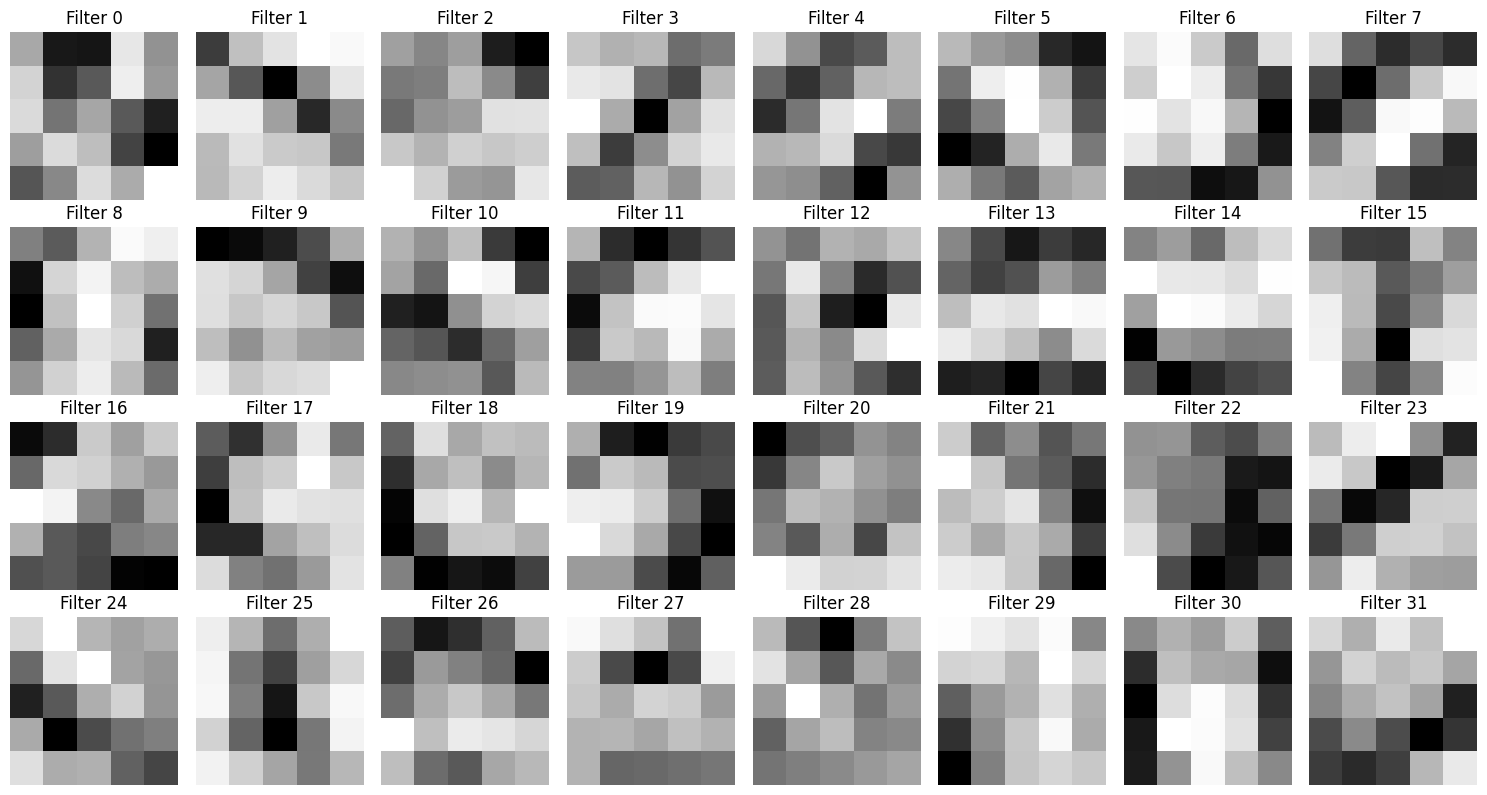

In [ ]:
# Überprüfe, ob die erste Schicht ein InputLayer ist:
if isinstance(model.layers[0], tf.keras.layers.InputLayer):
    print("Erste Schicht ist ein InputLayer. Verwende die zweite Schicht als conv_layer.")
    conv_layer = model.layers[1]
else:
    conv_layer = model.layers[0]

# Jetzt sollten wir Gewichte für die Convolution-Schicht erhalten:
weights = conv_layer.get_weights()
if len(weights) == 0:
    raise ValueError("Keine Gewichte in der gewählten conv_layer gefunden. Bitte überprüfe, ob dies wirklich eine Convolution-Schicht ist.")
else:
    filters, biases = weights[0], weights[1]

print("Filter-Shape:", filters.shape)  # Beispiel: (5, 5, 1, 32)
num_filters = filters.shape[-1]

plt.figure(figsize=(15, 8))
for i in range(num_filters):
    # Für MNIST (Graustufen) nehmen wir den ersten Input-Channel:
    f = filters[:, :, 0, i]
    ax = plt.subplot(4, 8, i+1)
    plt.imshow(f, cmap='gray')
    plt.axis("off")
    plt.title(f"Filter {i}")
plt.tight_layout()
plt.show()


Code: PCA der Dense-Layer-Embeddings

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Original shape der Embeddings: (10000, 28, 28, 1)
Embeddings nach Reshape: (10000, 784)


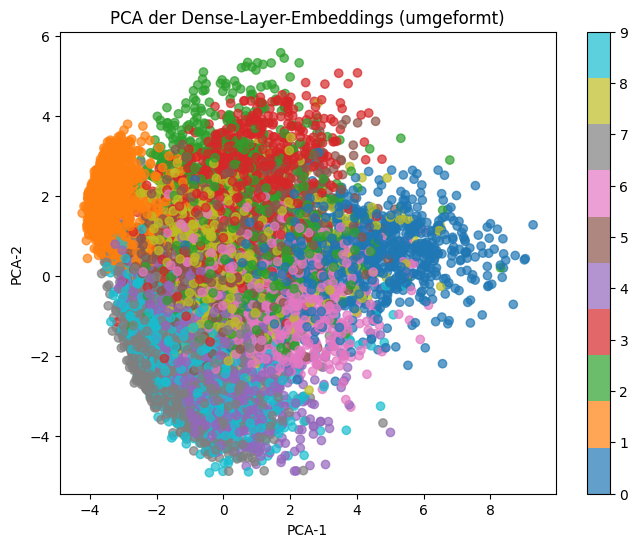

In [ ]:
# Dummy-Pass, um sicherzustellen, dass model.input definiert ist
_ = model.predict(test_images[:1])
dense_layer = model.layers[-2]  # Aktuell verwendeter Layer (z. B. Dropout)
embedding_model = Model(inputs=model.input, outputs=dense_layer.output)

embeddings = embedding_model.predict(test_images)
print("Original shape der Embeddings:", embeddings.shape)

# Falls die Ausgaben mehr als 2 Dimensionen haben, in 2D umformen:
if embeddings.ndim > 2:
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    print("Embeddings nach Reshape:", embeddings.shape)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=test_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("PCA der Dense-Layer-Embeddings (umgeformt)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.show()


Code: t-SNE der Dense-Layer-Embeddings

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 9.466s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.030841
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.566795
[t-SNE] KL divergence after 1000 iterations: 1.779172


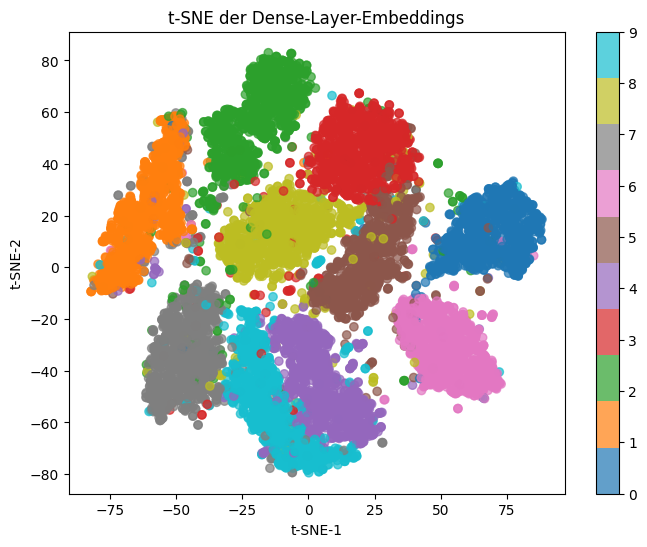

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1],
                      c=test_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE der Dense-Layer-Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()


Code: Speedrun-Modell trainieren und Ergebnisse plotten

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8652 - loss: 0.4885 - val_accuracy: 0.9631 - val_loss: 0.1191
Epoch 2/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9713 - loss: 0.0943 - val_accuracy: 0.9770 - val_loss: 0.0731
Epoch 3/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9826 - loss: 0.0600 - val_accuracy: 0.9800 - val_loss: 0.0622
Epoch 4/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9869 - loss: 0.0445 - val_accuracy: 0.9809 - val_loss: 0.0587
Epoch 5/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9902 - loss: 0.0343 - val_accuracy: 0.9815 - val_loss: 0.0560
Epoch 6/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9927 - loss: 0.0266 - val_accuracy: 0.9830 - val_loss: 0.0533
Epoch 7/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9949 - loss: 0.0200 - val_accuracy: 0.9841 - val_loss: 0.0538
Epoch 8/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9966 - loss: 0.0150 - val_accuracy: 0.

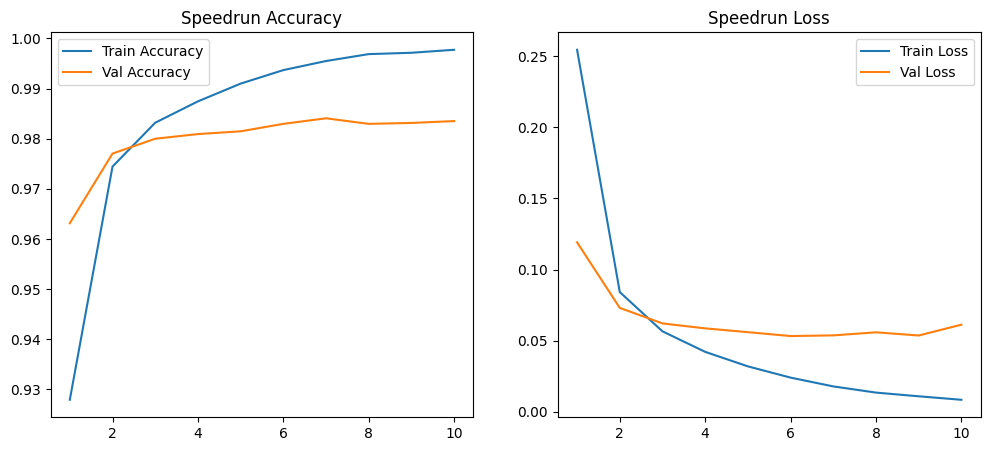

In [ ]:
model_speedrun = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model_speedrun.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_speedrun = model_speedrun.fit(
    X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=1
)

acc_speed = history_speedrun.history['accuracy']
val_acc_speed = history_speedrun.history['val_accuracy']
loss_speed = history_speedrun.history['loss']
val_loss_speed = history_speedrun.history['val_loss']
epochs_speed = range(1, len(acc_speed)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_speed, acc_speed, label='Train Accuracy')
plt.plot(epochs_speed, val_acc_speed, label='Val Accuracy')
plt.title('Speedrun Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_speed, loss_speed, label='Train Loss')
plt.plot(epochs_speed, val_loss_speed, label='Val Loss')
plt.title('Speedrun Loss')
plt.legend()
plt.show()


###########################################################################################

# 1. Modellvergleich und Ablationsstudien

In diesem Abschnitt vergleichen wir verschiedene Modellvarianten, um den Einfluss einzelner Bausteine zu untersuchen:
- **Variante A (Baseline):** Unser Standardmodell mit Dropout und BatchNormalization.
- **Variante B:** Modell *ohne Dropout* (aber mit BatchNormalization).
- **Variante C:** Modell *ohne BatchNormalization* (aber mit Dropout).

Wir trainieren alle Modelle (hier beispielhaft nur für 3 Epochen) und vergleichen am Ende ihre Testgenauigkeiten sowie den Trainingsverlauf.


Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 156s 180ms/step - accuracy: 0.8374 - loss: 0.5358 - val_accuracy: 0.9787 - val_loss: 0.0687
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 148s 175ms/step - accuracy: 0.9615 - loss: 0.1282 - val_accuracy: 0.9860 - val_loss: 0.0460
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 147s 175ms/step - accuracy: 0.9710 - loss: 0.0947 - val_accuracy: 0.9843 - val_loss: 0.0551
Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 152s 176ms/step - accuracy: 0.9093 - loss: 0.3094 - val_accuracy: 0.9777 - val_loss: 0.0703
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 145s 172ms/step - accuracy: 0.9777 - loss: 0.0706 - val_accuracy: 0.9700 - val_loss: 0.1013
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 143s 169ms/step - accuracy: 0.9840 - loss: 0.0521 - val_accuracy: 0.9743 - val_loss: 0.0874
Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 122s 143ms/step - accuracy: 0.7803 - loss: 0.6554 - val_accuracy: 0.9775 - val_loss: 0.0660
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 121s 143ms/step - accuracy: 0.9600 - loss: 0

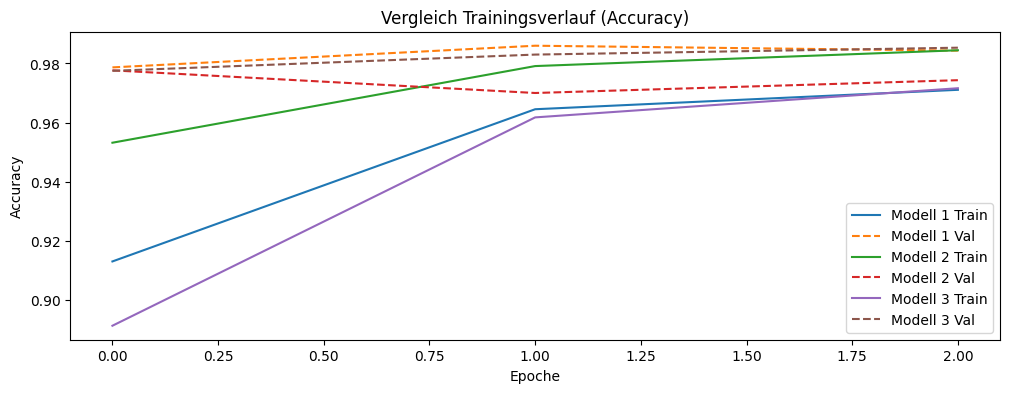

In [ ]:
def build_model_variant(dropout=True, batchnorm=True):
    layers = []
    # Erste Convolution-Schicht
    layers.append(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28,28,1)))
    if batchnorm:
        layers.append(BatchNormalization())
    layers.append(MaxPooling2D((2,2)))
    if dropout:
        layers.append(Dropout(0.2))

    # Zweite Convolution-Schicht
    layers.append(Conv2D(64, (3,3), padding='same', activation='relu'))
    if batchnorm:
        layers.append(BatchNormalization())
    layers.append(MaxPooling2D((2,2)))
    if dropout:
        layers.append(Dropout(0.3))

    layers.append(Flatten())
    layers.append(Dense(512, activation='relu'))
    if batchnorm:
        layers.append(BatchNormalization())
    if dropout:
        layers.append(Dropout(0.4))

    layers.append(Dense(10, activation='softmax'))
    return Sequential(layers)

# Trainingsparameter (hier für schnellen Vergleich: 3 Epochen)
EPOCHS_COMPARE = 3

# Baseline-Modell
model_A = build_model_variant(dropout=True, batchnorm=True)
model_A.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
history_A = model_A.fit(train_generator, epochs=EPOCHS_COMPARE, validation_data=val_generator, verbose=1)
test_loss_A, test_acc_A = model_A.evaluate(test_generator, verbose=0)

# Modell ohne Dropout
model_B = build_model_variant(dropout=False, batchnorm=True)
model_B.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
history_B = model_B.fit(train_generator, epochs=EPOCHS_COMPARE, validation_data=val_generator, verbose=1)
test_loss_B, test_acc_B = model_B.evaluate(test_generator, verbose=0)

# Modell ohne BatchNormalization
model_C = build_model_variant(dropout=True, batchnorm=False)
model_C.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
history_C = model_C.fit(train_generator, epochs=EPOCHS_COMPARE, validation_data=val_generator, verbose=1)
test_loss_C, test_acc_C = model_C.evaluate(test_generator, verbose=0)

print("Baseline (Dropout + BatchNorm) Test Accuracy:", test_acc_A)
print("Ohne Dropout Test Accuracy:", test_acc_B)
print("Ohne BatchNorm Test Accuracy:", test_acc_C)

# Optional: Plotten der Trainingsverläufe der drei Modelle
plt.figure(figsize=(12,4))
for i, history in enumerate([history_A, history_B, history_C], start=1):
    plt.plot(history.history['accuracy'], label=f'Modell {i} Train')
    plt.plot(history.history['val_accuracy'], label=f'Modell {i} Val', linestyle='--')
plt.title("Vergleich Trainingsverlauf (Accuracy)")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# 2. Analyse der Fehlklassifikationen

Hier untersuchen wir, welche Testbilder falsch klassifiziert wurden und wie groß die Differenz zwischen der
vom Modell vergebenen höchsten Wahrscheinlichkeit (p_pred) und der Wahrscheinlichkeit für das korrekte Label (p_true) ist.
Diese "Confidence-Differenz" hilft, herauszufinden, ob das Modell bei bestimmten Fehlern sehr zuversichtlich ist.


Anzahl falsch klassifizierter Bilder: 107


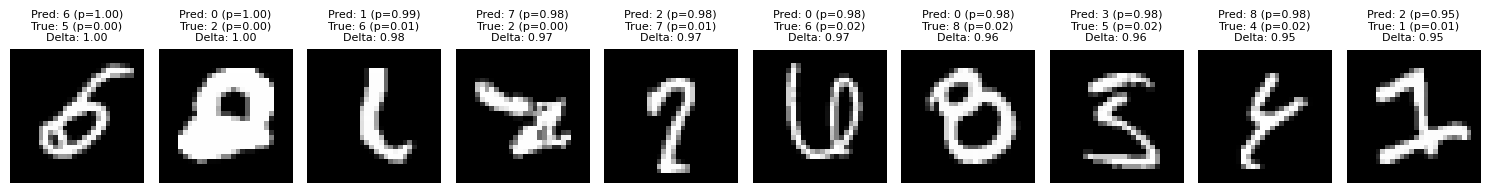

In [ ]:
# Vorhersagen für alle Testbilder (ohne Generator)
y_pred_prob = model.predict(test_images, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# Indizes der falsch klassifizierten Bilder
wrong_idx = np.where(y_pred != test_labels)[0]
# Wahrscheinlichkeiten
p_pred = y_pred_prob[wrong_idx, y_pred[wrong_idx]]
p_true = y_pred_prob[wrong_idx, test_labels[wrong_idx]]
delta = p_pred - p_true

# Sortiere falsch klassifizierte Bilder nach Delta (absteigend)
sort_idx = np.argsort(-delta)
wrong_idx_sorted = wrong_idx[sort_idx]
delta_sorted = delta[sort_idx]

print("Anzahl falsch klassifizierter Bilder:", len(wrong_idx_sorted))

# Zeige exemplarisch 10 falsch klassifizierte Bilder
num_to_show = 10
plt.figure(figsize=(15, 4))
for i in range(num_to_show):
    idx = wrong_idx_sorted[i]
    img = test_images[idx].reshape(28, 28)
    plt.subplot(1, num_to_show, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    title_str = (f"Pred: {y_pred[idx]} (p={p_pred[sort_idx[i]]:.2f})\n"
                 f"True: {test_labels[idx]} (p={p_true[sort_idx[i]]:.2f})\n"
                 f"Delta: {delta_sorted[i]:.2f}")
    plt.title(title_str, fontsize=8)
plt.tight_layout()
plt.show()


# 3. Visualisierungen der inneren Repräsentationen

In diesem Abschnitt betrachten wir:
- **Aktivierungskarten (Activation Maps):** Was passiert in der ersten Convolution-Schicht?
- **Filtervisualisierung:** Welche Filter (Gewichte) wurden in der ersten Conv2D-Schicht gelernt?
- **Embeddings mittels PCA/t-SNE:** Wie werden die Merkmale in der vorletzten Dense-Schicht (Embeddings) auf 2D reduziert und wie gut trennen sich die Klassen?


In [ ]:
# --- Aktivierungskarten (Activation Maps) ---
# Dummy-Pass, um sicherzustellen, dass model.input definiert ist
_ = model.predict(test_images[:1])

# Suche explizit nach der ersten Conv2D-Schicht im Modell
conv_layer = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_layer = layer
        break
if conv_layer is None:
    raise ValueError("Keine Conv2D-Schicht im Modell gefunden!")

# Erstelle ein Teilmodell, das die Ausgabe dieser Conv2D-Schicht liefert
activation_model = Model(inputs=model.input, outputs=conv_layer.output)
test_image = test_images[0][None, ...]
activation_maps = activation_model.predict(test_image)
print("Shape der Aktivierung nach der ersten Conv2D-Schicht:", activation_maps.shape)

num_filters = activation_maps.shape[-1]
plt.figure(figsize=(15, 8))
for i in range(num_filters):
    plt.subplot(4, 8, i+1)
    plt.imshow(activation_maps[0, :, :, i], cmap='viridis')
    plt.axis("off")
    plt.title(f"Map {i}", fontsize=8)
plt.tight_layout()
plt.show()

# --- Filtervisualisierung ---
filters, biases = conv_layer.get_weights()
print("Filter-Shape:", filters.shape)  # Beispiel: (5, 5, 1, 32)
num_filters = filters.shape[-1]
plt.figure(figsize=(15, 8))
for i in range(num_filters):
    f = filters[:, :, 0, i]
    plt.subplot(4, 8, i+1)
    plt.imshow(f, cmap='gray')
    plt.axis("off")
    plt.title(f"Filter {i}", fontsize=8)
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

In [ ]:
# Für diese Analyse benennen wir den Dense(512)-Layer als "dense_embedding".
# Falls du ihn noch nicht benannt hast, kannst du alternativ den vorletzten Layer verwenden.
# Hier verwenden wir:
dense_embedding = model.layers[-2]  # Wir erwarten, dass dieser Layer 2D-Ausgaben liefert

# Dummy-Pass, um sicherzustellen, dass model.input definiert ist
_ = model.predict(test_images[:1])
embedding_model = Model(inputs=model.input, outputs=dense_embedding.output)
embeddings = embedding_model.predict(test_images)
print("Shape der Embeddings:", embeddings.shape)  # z.B. (10000, 512)

# PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
plt.figure(figsize=(8,6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=test_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("PCA der Dense-Layer-Embeddings")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.show()

# t-SNE (Achtung: kann etwas Zeit in Anspruch nehmen)
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
embeddings_2d_tsne = tsne.fit_transform(embeddings)
plt.figure(figsize=(8,6))
scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1],
                      c=test_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE der Dense-Layer-Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Shape der Embeddings: (10000, 28, 28, 1)


ValueError: Found array with dim 4. PCA expected <= 2.

# 4. Experimente zur Robustheit und Generalisierbarkeit

Hier testen wir, wie robust unser Modell gegenüber Störungen ist.  
Wir fügen den Testbildern künstliches Rauschen hinzu und evaluieren, wie sich die Genauigkeit verändert.


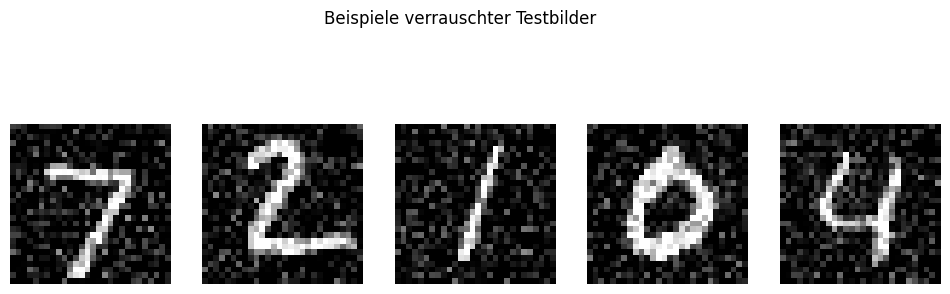

ValueError: You must call `compile()` before using the model.

In [ ]:
def add_gaussian_noise(images, mean=0.0, std=0.2):
    noisy_images = images + np.random.normal(mean, std, images.shape)
    # Clippe die Werte, damit sie im Bereich [0,1] bleiben
    return np.clip(noisy_images, 0.0, 1.0)

# Erstelle verrauschte Testbilder
noisy_test_images = add_gaussian_noise(test_images, std=0.2)

# Zeige ein paar Beispiele
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(noisy_test_images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle("Beispiele verrauschter Testbilder")
plt.show()

# Evaluierung des Modells auf verrauschten Bildern
test_loss_noisy, test_acc_noisy = model.evaluate(noisy_test_images, verbose=0)
print("Test Accuracy auf verrauschten Bildern:", test_acc_noisy)


# 5. Ensemble Learning

In diesem Abschnitt kombinieren wir die Vorhersagen zweier Modelle (z. B. unseres Basismodells und eines alternativen Modells)
durch Mittelung der Softmax-Ausgaben.  
Wir vergleichen so die Ensemble-Vorhersagen mit den Einzelvorhersagen.


In [ ]:
# Für das Ensemble verwenden wir unser Basismodell (model) und ein alternatives, minimalistischeres Modell (model_speedrun).
# Wir bauen ein kleines "Speedrun"-Modell, falls noch nicht vorhanden:
model_speedrun = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model_speedrun.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_speedrun = model_speedrun.fit(X_train, y_train, batch_size=64, epochs=3, validation_split=0.1, verbose=1)

# Einzelne Vorhersagen
preds_model1 = model.predict(test_images, verbose=0)
preds_model2 = model_speedrun.predict(test_images, verbose=0)

# Ensemble-Vorhersagen durch Mittelung
ensemble_preds = (preds_model1 + preds_model2) / 2.0
ensemble_y = np.argmax(ensemble_preds, axis=1)

# Vergleiche die Genauigkeit
from sklearn.metrics import accuracy_score
acc_model1 = accuracy_score(test_labels, np.argmax(preds_model1, axis=1))
acc_model2 = accuracy_score(test_labels, np.argmax(preds_model2, axis=1))
acc_ensemble = accuracy_score(test_labels, ensemble_y)

print("Test Accuracy Modell 1:", acc_model1)
print("Test Accuracy Modell 2:", acc_model2)
print("Test Accuracy Ensemble:", acc_ensemble)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
760/760 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.8645 - loss: 0.5098 - val_accuracy: 0.9676 - val_loss: 0.1126
Epoch 2/3
760/760 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9718 - loss: 0.0941 - val_accuracy: 0.9761 - val_loss: 0.0775
Epoch 3/3
760/760 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9825 - loss: 0.0619 - val_accuracy: 0.9796 - val_loss: 0.0642
Test Accuracy Modell 1: 0.9893
Test Accuracy Modell 2: 0.982
Test Accuracy Ensemble: 0.9911


# 6. Speedrunning / Ablation: Minimalistisches Modell

Hier trainieren wir ein stark vereinfachtes Modell ("Speedrun-Modell") und vergleichen dessen
Leistung (Trainingszeit, Modellgröße, Accuracy) mit dem komplexeren Modell.  
Dies zeigt, wie sehr die Modellkomplexität die Performance beeinflusst.


In [ ]:
model_speedrun = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model_speedrun.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_speedrun = model_speedrun.fit(
    X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=1
)

acc_speed = history_speedrun.history['accuracy']
val_acc_speed = history_speedrun.history['val_accuracy']
loss_speed = history_speedrun.history['loss']
val_loss_speed = history_speedrun.history['val_loss']
epochs_speed = range(1, len(acc_speed)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_speed, acc_speed, label='Train Accuracy')
plt.plot(epochs_speed, val_acc_speed, label='Val Accuracy')
plt.title('Speedrun Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_speed, loss_speed, label='Train Loss')
plt.plot(epochs_speed, val_loss_speed, label='Val Loss')
plt.title('Speedrun Model Loss')
plt.legend()
plt.show()

# Evaluierung
test_loss_speed, test_acc_speed = model_speedrun.evaluate(test_images, verbose=0)
print("Speedrun Model Test Accuracy:", test_acc_speed)


# 7. Interpretierbarkeit und Debugging

In diesem Abschnitt nutzen wir die bereits erstellten Visualisierungen und analysieren die Trainingsverläufe sowie
falsch klassifizierte Bilder, um Einblicke in das Verhalten des Modells zu gewinnen. Außerdem führen wir ein einfaches
Hyperparameter-Tuning durch (z. B. Variation der Lernrate), um zu sehen, wie sich diese Parameter auf den Trainingsverlauf auswirken.


In [ ]:
# Wir trainieren zwei Modelle für wenige Epochen (z. B. 3) mit unterschiedlichen Lernraten
def build_simple_model(lr):
    m = Sequential([
        Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    m.compile(optimizer=Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

lr_low = 0.0001
lr_high = 0.01

model_lr_low = build_simple_model(lr_low)
history_low = model_lr_low.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

model_lr_high = build_simple_model(lr_high)
history_high = model_lr_high.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_low.history['accuracy'], label=f'LR={lr_low} Train')
plt.plot(history_low.history['val_accuracy'], label=f'LR={lr_low} Val', linestyle='--')
plt.title("Trainingsverlauf (niedrige LR)")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_high.history['accuracy'], label=f'LR={lr_high} Train')
plt.plot(history_high.history['val_accuracy'], label=f'LR={lr_high} Val', linestyle='--')
plt.title("Trainingsverlauf (hohe LR)")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Interpretation:
print("Mit niedriger Lernrate konvergiert das Modell langsamer, während bei hoher Lernrate instabilere Trainingsverläufe auftreten können.")
